# STEP 1: Install Required Libraries

In [1]:
print("📦 Installing required libraries...")

!pip install -q alive-progress
!rm -rf BLIP
!git clone -q https://github.com/salesforce/BLIP.git
%cd BLIP

# Clean up old installs
!pip uninstall -y -q transformers tokenizers

# Install compatible versions
!pip install -q tokenizers==0.20.0
!pip install -q transformers==4.45.2 timm==0.4.12 fairscale==0.4.4
!pip install -q openai-clip
!pip install -q matplotlib seaborn

print("✅ Libraries installed successfully!")

📦 Installing required libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 4.0 MB/s eta 0:00:00
/content/BLIP
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 13.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.6 MB/s eta 0:00:00
✅ Libraries installe

# STEP 2: Download Dataset


In [2]:
import os
import time
import shutil
import zipfile
from urllib.request import urlretrieve
from urllib.error import HTTPError
from alive_progress import alive_bar

def download(index=1, range_max=None, output="images", unzip=False, large=False):
    baseurl = "https://huggingface.co/datasets/poloclub/diffusiondb/resolve/main/"
    files_to_unzip = []

    if not os.path.exists(output):
        os.makedirs(output)

    def get_url(idx):
        if large:
            if idx <= 10000:
                return f"{baseurl}diffusiondb-large-part-1/part-{idx:06}.zip"
            else:
                return f"{baseurl}diffusiondb-large-part-2/part-{idx:06}.zip"
        else:
            return f"{baseurl}images/part-{idx:06}.zip"

    if range_max is None:
        url = get_url(index)
        file_path = os.path.join(output, f"part-{index:06}.zip")
        print(f"Downloading file: {url}")
        try:
            urlretrieve(url, file_path)
        except HTTPError as e:
            print(f"HTTPError: {url} - {e}")
        if unzip:
            unzip_file(file_path)
    else:
        with alive_bar(range_max - index, title="Downloading files") as bar:
            for idx in range(index, range_max):
                url = get_url(idx)
                file_path = os.path.join(output, f"part-{idx:06}.zip")
                try:
                    urlretrieve(url, file_path)
                except HTTPError as e:
                    print(f"HTTPError: {url} - {e}")
                files_to_unzip.append(file_path)
                with open("manifest.txt", "a") as f:
                    f.write(url + "\n")
                time.sleep(0.1)
                bar()

        if unzip:
            unzip_all(files_to_unzip)

def unzip_file(file):
    folder_name = os.path.splitext(os.path.basename(file))[0]
    extract_path = os.path.join(os.path.dirname(file), folder_name)
    os.makedirs(extract_path, exist_ok=True)
    shutil.unpack_archive(file, extract_path)
    print(f"✅ Unzipped: {file} → {extract_path}")

def unzip_all(files):
    with alive_bar(len(files), title="Unzipping files") as bar:
        for file in files:
            unzip_file(file)
            time.sleep(0.1)
            bar()

print("📥 Downloading DiffusionDB dataset...")
download(index=1, range_max=6, output="/content/images", unzip=True, large=False)
print("✅ Dataset downloaded!")

📥 Downloading DiffusionDB dataset...
on 0: ✅ Unzipped: /content/images/part-000001.zip → /content/images/part-000001
on 1: ✅ Unzipped: /content/images/part-000002.zip → /content/images/part-000002
on 2: ✅ Unzipped: /content/images/part-000003.zip → /content/images/part-000003
on 3: ✅ Unzipped: /content/images/part-000004.zip → /content/images/part-000004
on 4: ✅ Unzipped: /content/images/part-000005.zip → /content/images/part-000005
Unzipping files |████████████████████████████████████████| 5/5 [100%] in 14.7s (0.34/s) 
✅ Dataset downloaded!


# STEP 3: Create CSV from JSON Metadata


In [3]:
import json
import pandas as pd
import glob

print("📋 Creating CSV from JSON metadata...")

base_dir = "/content/images"
json_files = glob.glob(os.path.join(base_dir, "part-*/part-*.json"))
print(f"Found {len(json_files)} JSON files")

all_records = []

for json_path in json_files:
    print(f"Processing {json_path}...")
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for filename, info in data.items():
        record = {
            "image_name": filename,
            "prompt": info.get("p", ""),
            "seed": info.get("se", ""),
            "cfg_scale": info.get("c", ""),
            "steps": info.get("st", ""),
            "sampler": info.get("sa", ""),
            "source_json": os.path.basename(json_path),
            "image_path": os.path.join(os.path.dirname(json_path), filename)
        }
        all_records.append(record)

df = pd.DataFrame(all_records)
output_csv = "/content/diffusiondb_combined.csv"
df.to_csv(output_csv, index=False, encoding="utf-8")

print(f"✅ CSV saved: {output_csv}")
print(f"Total records: {len(df)}")
print(df.head())

📋 Creating CSV from JSON metadata...
Found 5 JSON files
Processing /content/images/part-000003/part-000003.json...
Processing /content/images/part-000002/part-000002.json...
Processing /content/images/part-000001/part-000001.json...
Processing /content/images/part-000004/part-000004.json...
Processing /content/images/part-000005/part-000005.json...
✅ CSV saved: /content/diffusiondb_combined.csv
Total records: 5000
                                 image_name  \
0  12a24462-4dac-43c1-a145-89a25c72d815.png   
1  321da869-d2ce-49a0-b474-8c7650f5836a.png   
2  da698170-63cc-4ef9-81b7-44bd2bb51981.png   
3  aa221b88-e288-4373-8303-8dbaee77d793.png   
4  1642d94e-89db-4cca-9f84-66d7bad4f196.png   

                                              prompt        seed  cfg_scale  \
0  a surreal * * cognitive illusion * * of the ke...  2834113187        7.0   
1  photo cartoon illustration painting of small s...  1732026299        7.5   
2  photo cartoon illustration painting of small s...  17320262

# STEP 4: Data Validation

In [4]:
print("\n🔍 Validating dataset...")

print("Missing values per column:")
print(df.isnull().sum())

print("\nSample prompts:")
print(df["prompt"].dropna().sample(min(5, len(df))).tolist())

missing_images = df[~df["image_path"].apply(os.path.exists)]
print(f"⚠️ Missing image files: {len(missing_images)}")

df["prompt_length"] = df["prompt"].apply(lambda x: len(str(x).split()))
print("\nPrompt length stats:")
print(df["prompt_length"].describe())

# Remove rows with missing images
df = df[df["image_path"].apply(os.path.exists)]
df.to_csv("/content/diffusiondb_combined.csv", index=False)
print(f"✅ Cleaned dataset: {len(df)} valid records")


🔍 Validating dataset...
Missing values per column:
image_name     0
prompt         0
seed           0
cfg_scale      0
steps          0
sampler        0
source_json    0
image_path     0
dtype: int64

Sample prompts:
['art by brian reedy, a beautiful black ink linocut print of a skull and cross bones, 8 k, frostbite 3 engine, cryengine, ground level shot, dof, trending on artstation, digital art, crepuscular ray ', 'japanese manga, yoshiyuki tomino, battle mecha boy, broken mecha warrior, manga cover, hd, fine detail, detail works + tarot cards, cyberpunk style, hd, noise reduction, high contrast, unreal engine, 4 k, authors katsuhirootomo and yukito kishiro and trending on artstation ', 'tilt shift macro dirt, ant laying eggs ', 'amazon warrior mila kunis riding mounted on a fierce large white tiger, wintery scene, snow storm, donato giancola, mark brooks, ralph horsley, charlie bowater, artgerm, christopher balaskas, bastien lecouffe - deharme ', 'fujifilm film photo of terrifying b

# STEP 5: Load BLIP Model


In [5]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

print("\n🤖 Loading BLIP model...")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

print("✅ BLIP model loaded!")


🤖 Loading BLIP model...
Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

✅ BLIP model loaded!


# STEP 6: Test BLIP on Single Image

In [6]:
print("\n🧪 Testing BLIP on single image...")

sample = df.iloc[0]
print(f"Prompt: {sample['prompt']}")
print(f"Image path: {sample['image_path']}")

image = Image.open(sample['image_path']).convert('RGB')
inputs = processor(image, return_tensors="pt").to(device)
out = model_blip.generate(**inputs)
caption = processor.decode(out[0], skip_special_tokens=True)
print(f"Generated Caption: {caption}")


🧪 Testing BLIP on single image...
Prompt: a surreal * * cognitive illusion * * of the key of the universe, by oleg shupliak and jeffrey smith, oil on canvas, surrealism 
Image path: /content/images/part-000003/12a24462-4dac-43c1-a145-89a25c72d815.png


/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated Caption: a painting of a man standing in front of a giant planet


# STEP 7: Generate BLIP Captions for ALL Images

In [7]:
from tqdm import tqdm
import torch
from PIL import Image

print("\n📝 Generating BLIP captions (Optimized Batch Processing)...")

# Auto-detect batch size
gpu_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
if "T4" in gpu_name:
    BATCH_SIZE = 8
elif "V100" in gpu_name or "A100" in gpu_name:
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 16

print(f"🎯 GPU: {gpu_name} | Batch Size: {BATCH_SIZE}")

blip_captions = []
num_batches = (len(df) + BATCH_SIZE - 1) // BATCH_SIZE

for batch_idx in tqdm(range(num_batches), desc="BLIP Captioning"):
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, len(df))

    batch_images = []
    batch_valid = []

    # Load batch
    for idx in range(start_idx, end_idx):
        row = df.iloc[idx]
        img_path = row["image_path"]

        if os.path.exists(img_path):
            try:
                image = Image.open(img_path).convert('RGB')
                batch_images.append(image)
                batch_valid.append(True)
            except:
                batch_valid.append(False)
        else:
            batch_valid.append(False)

    # Process valid images
    if batch_images:
        try:
            inputs = processor(images=batch_images, return_tensors="pt", padding=True).to(device)

            with torch.no_grad():
                outputs = model_blip.generate(**inputs, max_length=50, num_beams=1)  # num_beams=1 for speed

            captions = processor.batch_decode(outputs, skip_special_tokens=True)

            # Merge results
            caption_idx = 0
            for is_valid in batch_valid:
                if is_valid:
                    blip_captions.append(captions[caption_idx])
                    caption_idx += 1
                else:
                    blip_captions.append("")
        except Exception as e:
            print(f"⚠️ Batch {batch_idx} error: {e}")
            blip_captions.extend([""] * len(batch_valid))

    # Clear cache every 10 batches
    if batch_idx % 10 == 0 and torch.cuda.is_available():
        torch.cuda.empty_cache()

# Save results
df['blip_caption'] = blip_captions
df.to_csv("/content/diffusiondb_with_captions.csv", index=False)

valid_captions = sum([1 for c in blip_captions if c.strip() != ""])
print(f"✅ BLIP captions generated!")
print(f"   Valid: {valid_captions}/{len(df)} ({valid_captions/len(df)*100:.1f}%)")


📝 Generating BLIP captions (Optimized Batch Processing)...
🎯 GPU: Tesla T4 | Batch Size: 8


BLIP Captioning: 100%|██████████| 625/625 [14:24<00:00,  1.38s/it]

✅ BLIP captions generated!
   Valid: 5000/5000 (100.0%)


# STEP 8: Load CLIP Model

In [8]:
import clip

print("\n🤖 Loading CLIP model...")

model_clip, preprocess = clip.load("ViT-B/32", device=device)
print("✅ CLIP model loaded!")


🤖 Loading CLIP model...


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 69.8MiB/s]


✅ CLIP model loaded!


# STEP 9: Test CLIP on Single Image

In [9]:
print("\n🧪 Testing CLIP on single image...")

image = Image.open(sample['image_path']).convert('RGB')
image_input = preprocess(image).unsqueeze(0).to(device)
text_input = clip.tokenize([sample['prompt'], caption]).to(device)

with torch.no_grad():
    image_features = model_clip.encode_image(image_input)
    text_features = model_clip.encode_text(text_input)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * image_features @ text_features.T)

print("Similarity Matrix:")
print(similarity.cpu().numpy())



🧪 Testing CLIP on single image...
Similarity Matrix:
[[28.72 31.75]]


# STEP 10: Compute CLIP Similarities for ALL Images

In [10]:
print("\n🔢 Computing CLIP similarities for all images...")

df = pd.read_csv("/content/diffusiondb_with_captions.csv")
clip_results = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="CLIP Similarity"):
    img_path = row["image_path"]
    prompt = str(row["prompt"])
    caption = str(row["blip_caption"])

    if not os.path.exists(img_path) or caption == "" or caption == "nan":
        continue

    try:
        image = Image.open(img_path).convert("RGB")
        image_input = preprocess(image).unsqueeze(0).to(device)
        text_input = clip.tokenize([prompt, caption], truncate=True).to(device)

        with torch.no_grad():
            image_features = model_clip.encode_image(image_input)
            text_features = model_clip.encode_text(text_input)

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            similarity = (100.0 * image_features @ text_features.T).squeeze().cpu().numpy()

        clip_results.append({
            "image_path": img_path,
            "image_name": row["image_name"],
            "prompt": prompt,
            "blip_caption": caption,
            "clip_similarity_prompt": float(similarity[0]),
            "clip_similarity_caption": float(similarity[1]),
            "similarity_diff": float(similarity[0] - similarity[1])
        })

    except Exception as e:
        print(f"⚠️ Error: {e}")
        continue

    if idx % 100 == 0:
        torch.cuda.empty_cache()

results_df = pd.DataFrame(clip_results)
results_df.to_csv("/content/clip_similarity_results.csv", index=False)
print(f"✅ CLIP results saved! Total: {len(results_df)} samples")



🔢 Computing CLIP similarities for all images...


CLIP Similarity: 100%|██████████| 5000/5000 [03:17<00:00, 25.31it/s]

✅ CLIP results saved! Total: 5000 samples


# STEP 11: Statistical Analysis & Visualization


📊 Performing statistical analysis...
📊 STATISTICAL SUMMARY

🔹 Prompt-Image Similarity:
count    5000.000000
mean       32.045027
std         4.031656
min         5.187500
25%        29.593750
50%        32.218750
75%        34.718750
max        46.000000
Name: clip_similarity_prompt, dtype: float64

🔹 Caption-Image Similarity:
count    5000.000000
mean       28.934144
std         3.595302
min        15.734375
25%        26.546875
50%        28.968750
75%        31.359375
max        40.218750
Name: clip_similarity_caption, dtype: float64

🔹 Similarity Difference:
count    5000.000000
mean        3.110883
std         4.580416
min       -19.687500
25%         0.015625
50%         2.906250
75%         6.093750
max        21.750000
Name: similarity_diff, dtype: float64

✅ TOP 10 BEST MATCHES:
                                    image_name  \
4283  2ec22b92-65d0-4abc-9779-d7681c11f9a2.png   
4188  3c549e16-34df-4682-a8b6-ca7ddfdbcbad.png   
2250  fd592486-e3ef-421b-a536-47a1a0240a7b.png   


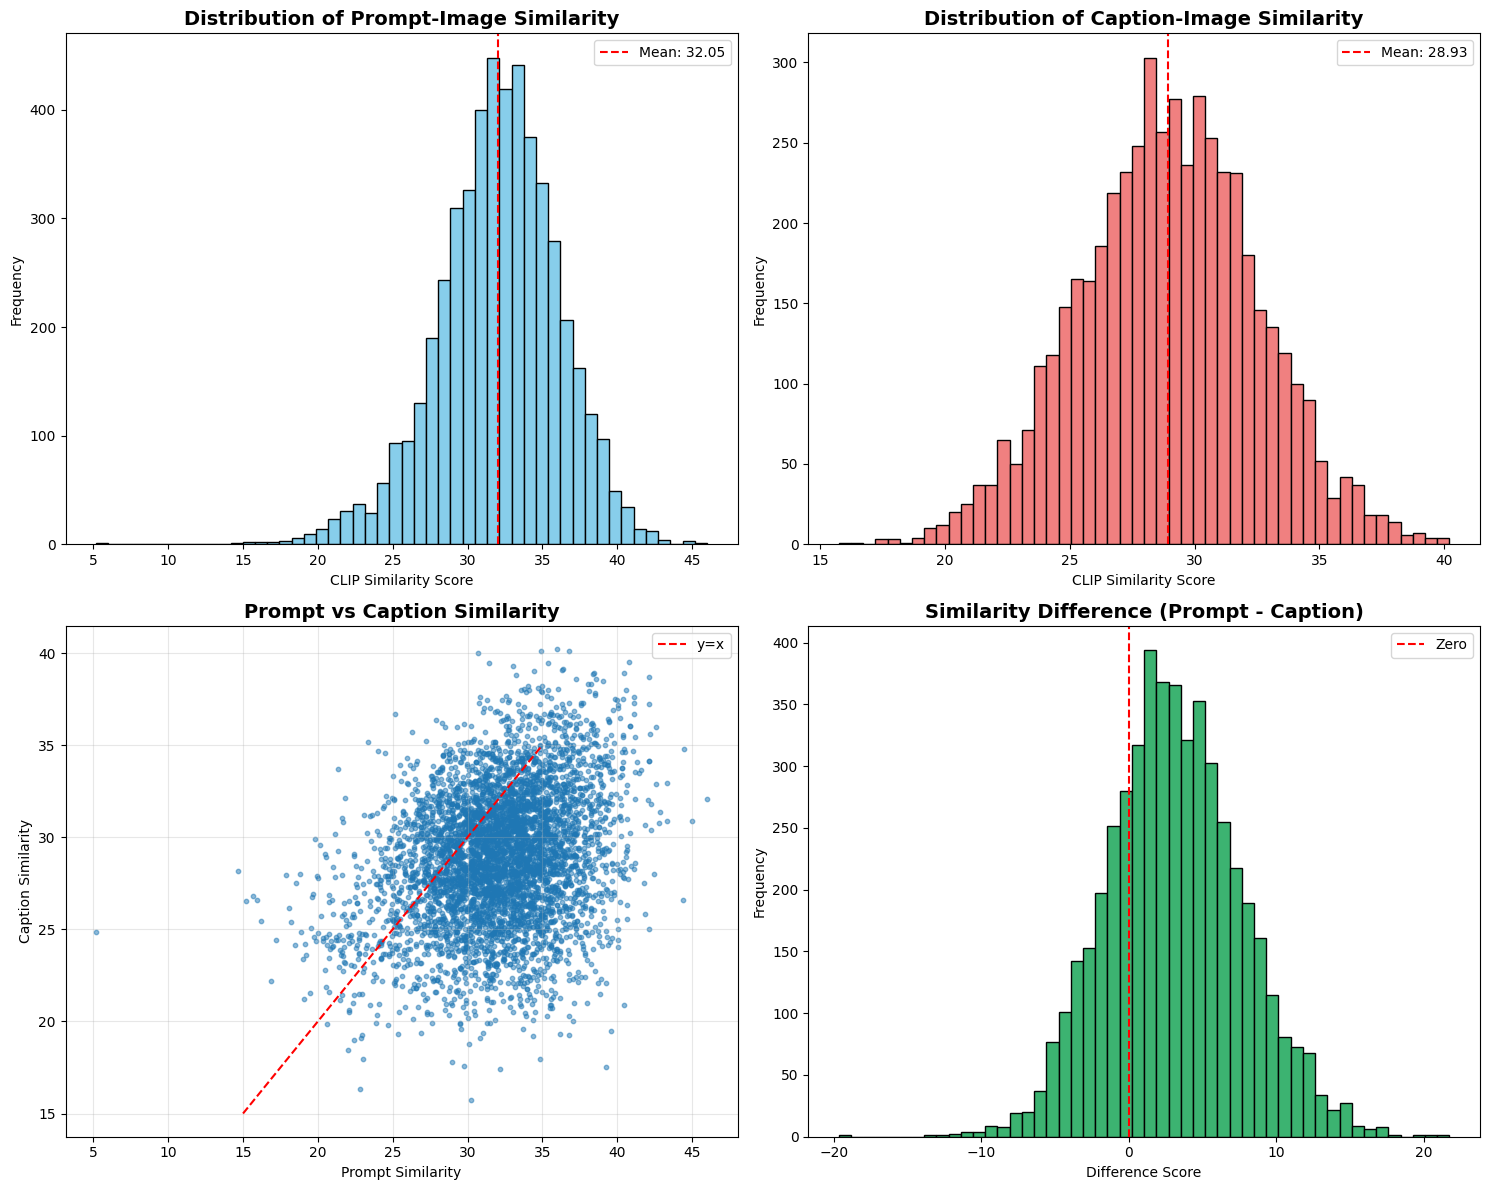

✅ Visualizations saved!


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n📊 Performing statistical analysis...")

results_df = pd.read_csv("/content/clip_similarity_results.csv")

print("="*60)
print("📊 STATISTICAL SUMMARY")
print("="*60)

print("\n🔹 Prompt-Image Similarity:")
print(results_df['clip_similarity_prompt'].describe())

print("\n🔹 Caption-Image Similarity:")
print(results_df['clip_similarity_caption'].describe())

print("\n🔹 Similarity Difference:")
print(results_df['similarity_diff'].describe())

print("\n✅ TOP 10 BEST MATCHES:")
print(results_df.nlargest(10, 'clip_similarity_prompt')[['image_name', 'prompt', 'clip_similarity_prompt']])

print("\n⚠️ TOP 10 WORST MATCHES:")
print(results_df.nsmallest(10, 'clip_similarity_prompt')[['image_name', 'prompt', 'clip_similarity_prompt']])

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Prompt Similarity Distribution
axes[0, 0].hist(results_df['clip_similarity_prompt'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Prompt-Image Similarity', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('CLIP Similarity Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(results_df['clip_similarity_prompt'].mean(), color='red', linestyle='--',
                   label=f'Mean: {results_df["clip_similarity_prompt"].mean():.2f}')
axes[0, 0].legend()

# Caption Similarity Distribution
axes[0, 1].hist(results_df['clip_similarity_caption'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Caption-Image Similarity', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('CLIP Similarity Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(results_df['clip_similarity_caption'].mean(), color='red', linestyle='--',
                   label=f'Mean: {results_df["clip_similarity_caption"].mean():.2f}')
axes[0, 1].legend()

# Scatter Plot
axes[1, 0].scatter(results_df['clip_similarity_prompt'], results_df['clip_similarity_caption'],
                   alpha=0.5, s=10)
axes[1, 0].plot([15, 35], [15, 35], 'r--', label='y=x')
axes[1, 0].set_title('Prompt vs Caption Similarity', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Prompt Similarity')
axes[1, 0].set_ylabel('Caption Similarity')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Difference Distribution
axes[1, 1].hist(results_df['similarity_diff'], bins=50, color='mediumseagreen', edgecolor='black')
axes[1, 1].set_title('Similarity Difference (Prompt - Caption)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Difference Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(0, color='red', linestyle='--', label='Zero')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('/content/analysis_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved!")

# STEP 12: Visual Inspection of Examples


🖼️ Visualizing best and worst matches...


/tmp/ipython-input-1860641551.py:23: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1860641551.py:24: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(f'/content/{title.split()[1].lower()}_matches.png', dpi=200)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


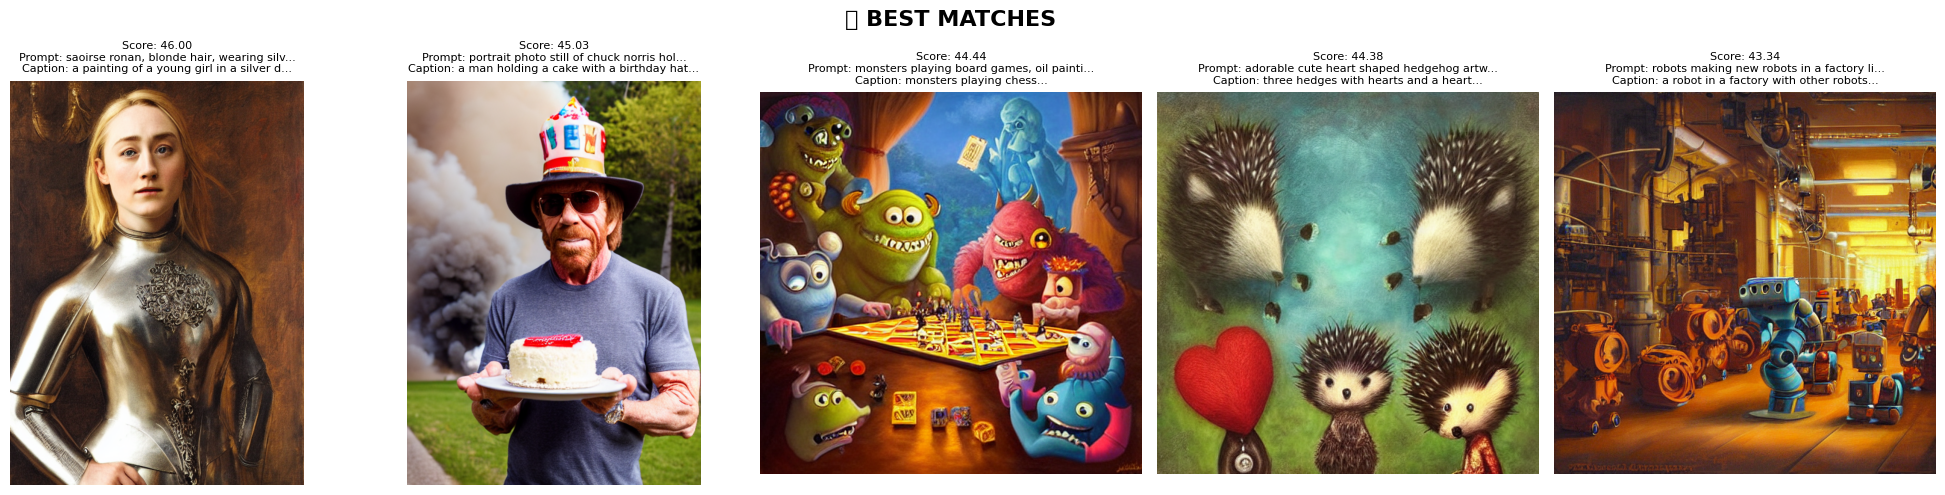

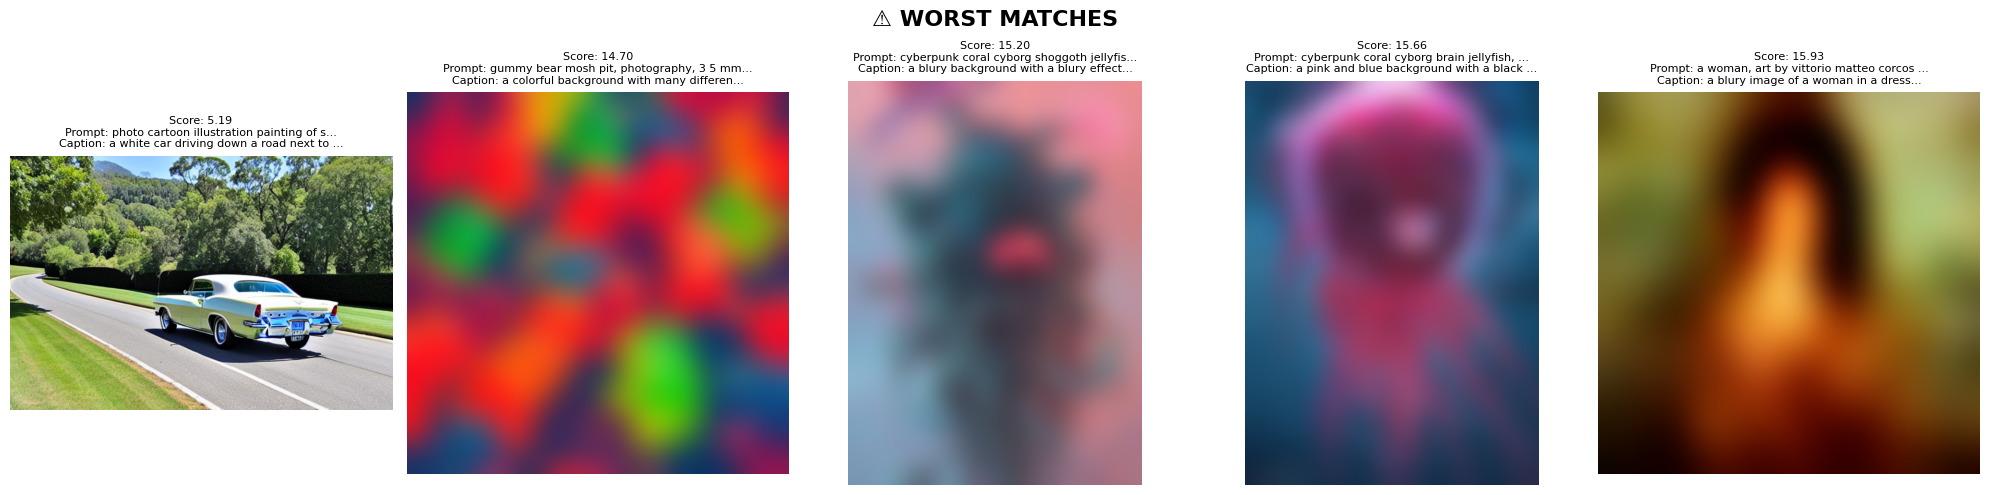

In [12]:
def display_samples(df, n=5, best=True):
    if best:
        samples = df.nlargest(n, 'clip_similarity_prompt')
        title = "✅ BEST MATCHES"
    else:
        samples = df.nsmallest(n, 'clip_similarity_prompt')
        title = "⚠️ WORST MATCHES"

    fig, axes = plt.subplots(1, n, figsize=(20, 5))

    for idx, (i, row) in enumerate(samples.iterrows()):
        img = Image.open(row['image_path']).convert('RGB')
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(
            f"Score: {row['clip_similarity_prompt']:.2f}\n" +
            f"Prompt: {row['prompt'][:40]}...\n" +
            f"Caption: {row['blip_caption'][:40]}...",
            fontsize=8
        )

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'/content/{title.split()[1].lower()}_matches.png', dpi=200)
    plt.show()

print("\n🖼️ Visualizing best and worst matches...")
display_samples(results_df, n=5, best=True)
display_samples(results_df, n=5, best=False)


# STEP 13: Generate Final Report

In [13]:
report = f"""
{'='*70}
AI IMAGE PROMPT-OUTPUT MATCH ANALYSIS REPORT
{'='*70}

📊 DATASET STATISTICS
{'='*70}
Total Images Analyzed: {len(results_df)}
Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

{'='*70}
📈 SIMILARITY SCORES
{'='*70}

Prompt-Image Similarity:
  Mean:     {results_df['clip_similarity_prompt'].mean():.4f}
  Median:   {results_df['clip_similarity_prompt'].median():.4f}
  Std Dev:  {results_df['clip_similarity_prompt'].std():.4f}
  Min:      {results_df['clip_similarity_prompt'].min():.4f}
  Max:      {results_df['clip_similarity_prompt'].max():.4f}

Caption-Image Similarity:
  Mean:     {results_df['clip_similarity_caption'].mean():.4f}
  Median:   {results_df['clip_similarity_caption'].median():.4f}
  Std Dev:  {results_df['clip_similarity_caption'].std():.4f}
  Min:      {results_df['clip_similarity_caption'].min():.4f}
  Max:      {results_df['clip_similarity_caption'].max():.4f}

{'='*70}
🔍 KEY INSIGHTS
{'='*70}

1. Average Match Quality: {results_df['clip_similarity_prompt'].mean():.2f}/100
2. High-Quality Matches (>25): {(results_df['clip_similarity_prompt'] > 25).sum() / len(results_df) * 100:.2f}%
3. Poor Matches (<20): {(results_df['clip_similarity_prompt'] < 20).sum() / len(results_df) * 100:.2f}%
4. Avg Prompt vs Caption Diff: {results_df['similarity_diff'].mean():.4f}

{'='*70}
📁 OUTPUT FILES
{'='*70}
- clip_similarity_results.csv
- analysis_results.png
- best_matches.png
- worst_matches.png
- analysis_report.txt

{'='*70}
"""

print(report)

with open('/content/analysis_report.txt', 'w') as f:
    f.write(report)

print("✅ Report saved!")

print("\n" + "="*70)
print("🎉 ANALYSIS COMPLETE!")
print("="*70)
print("\n📁 All output files are in /content/")
print("📊 Download them from Colab's file browser")


AI IMAGE PROMPT-OUTPUT MATCH ANALYSIS REPORT

📊 DATASET STATISTICS
Total Images Analyzed: 5000
Date: 2025-10-30 06:34:20

📈 SIMILARITY SCORES

Prompt-Image Similarity:
  Mean:     32.0450
  Median:   32.2188
  Std Dev:  4.0317
  Min:      5.1875
  Max:      46.0000

Caption-Image Similarity:
  Mean:     28.9341
  Median:   28.9688
  Std Dev:  3.5953
  Min:      15.7344
  Max:      40.2188

🔍 KEY INSIGHTS

1. Average Match Quality: 32.05/100
2. High-Quality Matches (>25): 95.22%
3. Poor Matches (<20): 0.56%
4. Avg Prompt vs Caption Diff: 3.1109

📁 OUTPUT FILES
- clip_similarity_results.csv
- analysis_results.png
- best_matches.png
- worst_matches.png
- analysis_report.txt


✅ Report saved!

🎉 ANALYSIS COMPLETE!

📁 All output files are in /content/
📊 Download them from Colab's file browser
